In [ ]:
# 

In [304]:
import pandas as pd
from pathlib import Path
import sqlite3
from datetime import datetime
import traceback
import dtale
import re

# Move data to sql database for easier querying and connectecting

In [23]:
list(Path('data').glob('*.csv'))

[PosixPath('data/books.csv'),
 PosixPath('data/libraries.csv'),
 PosixPath('data/checkouts.csv'),
 PosixPath('data/customers.csv')]

In [19]:
# str(a)

In [22]:
conn = sqlite3.connect("data/library_example.db")  # This will create 'example.db' in the current directory

# conn.close()

In [21]:
for csv_path in Path('data').glob('*.csv'):
    table_name = csv_path.stem
    print(table_name)
    temp_df = pd.read_csv(csv_path)
    temp_df.to_sql(name=table_name, con=conn, if_exists="replace", index=False)

conn.close()

books
libraries
checkouts
customers


In [131]:
checkouts_df = pd.read_csv('data/checkouts.csv')

In [103]:
checkouts_df.head(2)

,id,patron_id,library_id,date_checkout,date_returned
0,-xFj0vTLbRIC,b071c9c68228a2b1d00e6f53677e16da,225-222@5xc-jtz-hkf,2019-01-28,2018-11-13
1,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,223-222@5xc-jxr-tgk,2018-05-29,2018-06-12


In [104]:
checkouts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2000 non-null   object
 1   patron_id      2000 non-null   object
 2   library_id     2000 non-null   object
 3   date_checkout  1935 non-null   object
 4   date_returned  1942 non-null   object
dtypes: object(5)
memory usage: 78.3+ KB


In [105]:
# checkouts_df['date_checkout'] = pd.to_datetime(checkouts_df['date_checkout'], format='mixed')
# checkouts_df['date_returned'] = pd.to_datetime(checkouts_df['date_returned'], format='mixed')

In [106]:
# date_str

Since PDF with assigments has been created 2021-04-09, and dataset has not 2021 and 2017 in it, I will use those as cutoff dates.

In [135]:
checkouts_df["date_returned"] = checkouts_df["date_returned"].fillna('')
checkouts_df[checkouts_df["date_returned"].str.contains('2021')]


,id,patron_id,library_id,date_checkout,date_returned


In [136]:
checkouts_df["date_checkout"] = checkouts_df["date_checkout"].fillna('')
checkouts_df[checkouts_df["date_checkout"].str.contains('2021')]

,id,patron_id,library_id,date_checkout,date_returned


In [235]:
checkouts_df = pd.read_csv('data/checkouts.csv')

In [236]:
checkouts_df["date_checkout"] = checkouts_df["date_checkout"].fillna('2017-12-31') # this is bad data
checkouts_df["date_returned"] = checkouts_df["date_returned"].fillna('2021-04-09') # not yet returned

We have many different date formats, dates in the past, dates in the future. This would prompt me to get in touch with aplicaiton developers to implement data verification on data entry form. This is not only affecting our analisys, but work of the libraries.  

In [237]:
date_formats = ["%Y-%m-%d", "%Y/%m/%d" , "%Y%m%d", "%Y|%m|%d", "%Y %m %d", "%Y", "%Y-%m"]

# Function to check if a date matches any of the specified formats
def is_valid_date(date_str, formats):
    date_str = date_str.replace('%', '')
    date_str = date_str.strip()

    for fmt in formats:
        try:
            # Try to parse the date with the current format
            return datetime.strptime(date_str, fmt)
        except Exception as e:

            continue
    print(date_str)
    return None  # Return None if no format matches


# Apply the function to check validity of each date
checkouts_df["date_checkout"] = checkouts_df["date_checkout"].apply(lambda x: is_valid_date(x, date_formats))
checkouts_df["date_returned"] = checkouts_df["date_returned"].apply(lambda x: is_valid_date(x, date_formats))

In [238]:
checkouts_df['length'] = checkouts_df.date_returned - checkouts_df.date_checkout
checkouts_df['length'] = checkouts_df.length.dt.days

In [239]:
# date_checkout before 2018-01-01 are all 1800 and invalid, including 2017-12-31 which is NA
checkouts_df[checkouts_df.date_checkout<='2017-12-31'].shape 

(155, 6)

In [240]:
checkouts_df = checkouts_df[checkouts_df.date_checkout>'2017-12-31']

loans retruned after 2021-04-09 are illegal dates, not contributing to our analisys

In [241]:
checkouts_df[checkouts_df.date_returned>'2021-04-09'].shape

(95, 6)

In [242]:
checkouts_df[checkouts_df.date_returned=='2021-04-09'].shape

(58, 6)

In [243]:
checkouts_df = checkouts_df[checkouts_df.date_returned<='2021-04-09']

In [244]:
checkouts_df[checkouts_df.length<0].shape

(241, 6)

In [245]:
checkouts_df = checkouts_df[~checkouts_df.length<0]

In [246]:
checkouts_df[checkouts_df.length<=28].shape

(1319, 6)

<Axes: >

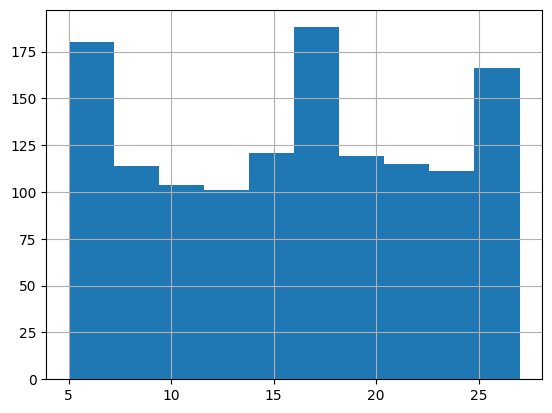

In [247]:
checkouts_df[checkouts_df.length<=28].length.hist()

Data looks sythetic, I would expect  Poisson Probability Distribution here, while this is more uniform, let's see further. Maybe 28 day cutoff is affecting distribution.

In [248]:
checkouts_df[checkouts_df.length>28].shape

(190, 6)

<Axes: >

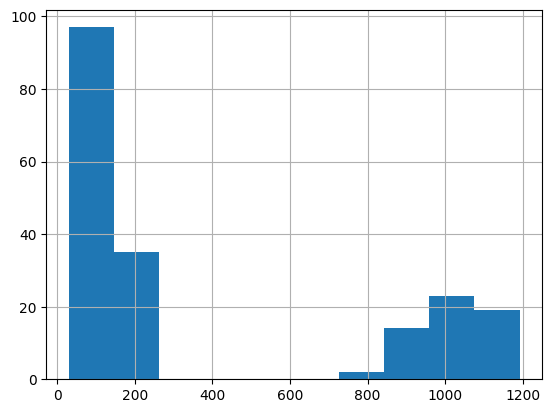

In [249]:
checkouts_df[checkouts_df.length>28].length.hist()

In [250]:
dtale.show(checkouts_df.sort_values(by='date_checkout'))

In [251]:
checkouts_df.to_csv('checkouts_df_clean.csv')

In [252]:
checkouts_df

,id,patron_id,library_id,date_checkout,date_returned,length
1,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,223-222@5xc-jxr-tgk,2018-05-29,2018-06-12,14
2,TQpFnkku2poC,4ae202f8de762591734705e0079d76df,228-222@5xc-jtz-hwk,2018-11-23,2019-01-24,62
3,OQ6sDwAAQBAJ,f9372de3c8ea501601aa3fb59ec0f524,23v-222@5xc-jv7-v4v,2018-01-15,2018-04-25,100
6,CW-7tHAaVR0C,dd9f34e9d65126a2b02003d8ac60aaa4,22c-222@5xc-jwj-pvz,2018-01-10,2018-02-04,25
8,t1e3BWziAc8C,3b85b2c7b424618f533329018e9a11d5,222-222@5xc-jv5-nt9,2018-06-23,2018-07-14,21
...,...,...,...,...,...,...
1995,rNbuDwAAQBAJ,91871955f3641857832766ac3f5a0b95,222-222@5xc-jv5-nt9,2018-07-19,2018-08-12,24
1996,rcrCAgAAQBAJ,ad08956eb20efb746af650f906d439cf,22d-222@5xc-kcy-8sq,2018-03-07,2018-03-13,6
1997,F44fAQAAMAAJ,026262cc3454149303074c4113b5f118,226-222@5xc-jxj-7yv,2018-06-17,2018-06-27,10
1998,Ci1HAQAAMAAJ,08b29865e58e9b2aabff9684a703acf0,223-222@5xc-jxr-tgk,2018-12-10,2018-12-29,19


# Books

In [335]:
books_df = pd.read_csv('data/books.csv').add_prefix('book_')

In [336]:
books_df.columns

Index(['book_id', 'book_title', 'book_authors', 'book_publisher',
       'book_publishedDate', 'book_categories', 'book_price', 'book_pages'],
      dtype='object')

In [337]:
def clean_price(price):
    # Keep only valid float characters (digits, '.', '-', optional ',' for formatting)
    cleaned = re.sub(r"[^\d\.-]", "", price)
    # Ensure valid float format by checking if it can be converted
    try:
        return float(cleaned)
    except ValueError:
        return None  # Return None for invalid prices\


def clean_page_count(page_count):
    # Keep only digits
    cleaned = re.sub(r"[^\d]", "", page_count)
    # Ensure valid integer format by checking if it's non-empty
    try:
        return int(cleaned) if cleaned else None
    except ValueError:
        return None  # Return None for invalid page counts

In [338]:
books_df['book_authors'] = books_df['book_authors'].fillna("['NO_AUTHOR']")
books_df['book_publisher'] = books_df['book_publisher'].fillna("['NO_PUBLISHER']")
books_df['book_publishedDate'] = books_df['book_publishedDate'].fillna('2021-04-09')

date_formats = ["%Y-%m-%d", "%Y", "%Y-%m"] #"%Y/%m/%d" , "%Y%m%d", "%Y|%m|%d", "%Y %m %d", 
books_df['book_publishedDate'] = books_df['book_publishedDate'].apply(lambda x: is_valid_date(x, date_formats))
books_df['book_published_year'] = books_df.book_publishedDate.dt.year

books_df['book_categories'] = books_df['book_categories'].fillna("['NO_CATEGORY']")

books_df["book_price"] = books_df["book_price"].fillna("0.0")
books_df["book_price"] = books_df.book_price.apply(lambda x: clean_price(x))

books_df["book_pages"] = books_df.book_pages.apply(lambda x: clean_page_count(x))

# Customers

In [340]:
customers_df = pd.read_csv('data/customers.csv').add_prefix('customer_')

libraries_df = pd.read_csv('data/libraries.csv').add_prefix('library_')

In [341]:
customers_df.columns

Index(['customer_id', 'customer_name', 'customer_street_address',
       'customer_city', 'customer_state', 'customer_zipcode',
       'customer_birth_date', 'customer_gender', 'customer_education',
       'customer_occupation'],
      dtype='object')

In [348]:
customers_df[customers_df.customer_city.isna()][['customer_city', 'customer_state']].drop_duplicates()

,customer_city,customer_state
4,NaN,Oregon
31,NaN,Oregon
203,NaN,NaN
241,NaN,OREGON
557,NaN,Washington
558,NaN,oregon
567,NaN,Oregon


In [350]:
customers_df.customer_city.unique()

array(['Portland ', ' Portland', 'Portland', nan, 'Happy Valley',
       'Lake Oswego', 'Vancouver', 'Beaverton', 'PORTLAND', 'Gresham',
       'West Linn', 'Vancouver ', 'Tualatin', 'Oregon City', 'Damascus',
       'portland', 'Clackamas', ' Vancouver', 'Hillsboro', 'Lake  Oswego',
       'Lake OSWEGO', 'Happy  Valley', 'Lake   Oswego', 'VANCOUVER',
       'vancouver', 'Gladstone', 'BEAVERTON', 'HAPPY Valley', 'CLACKAMAS',
       'LAKE OSWEGO', 'Happy  Valley ', ' Beaverton', 'Happy Valley '],
      dtype=object)

2025-01-02 17:10:12,966 - INFO     - Executing shutdown due to inactivity...
2025-01-02 17:10:12,975 - INFO     - Executing shutdown...
2025-01-02 17:10:12,976 - INFO     - Not running with the Werkzeug Server, exiting by searching gc for BaseWSGIServer


In [349]:
customers_df.customer_state.unique()

array(['Oregon', 'OREGON', 'Washington', nan, 'Oregon ', ' Oregon',
       ' Washington', 'oregon', 'Washington ', 'washington'], dtype=object)

In [347]:
customers_df[['customer_city', 'customer_state']].drop_duplicates()

,customer_city,customer_state
0,Portland,Oregon
1,Portland,Oregon
2,Portland,Oregon
4,NaN,Oregon
7,Happy Valley,Oregon
...,...,...
1802,Happy Valley,Oregon
1805,Portland,oregon
1936,Beaverton,Oregon
1956,Happy Valley,Oregon


In [344]:
dtale.show(customers_df[['customer_city']])

In [255]:
customers_df.head(3)

,id,name,street_address,city,state,zipcode,birth_date,gender,education,occupation
0,df83ec2d0d409395c0d8c2690cfa8b67,Cynthia Barnfield,44 NE Meikle Pl,Portland,Oregon,97213.0,2009-09-10,female,High School,NaN
1,6aec7ab2ea0d67161dac39e5dcabd857,Elizabeth Smith,7511 SE Harrison St,Portland,Oregon,97215.0,1956-12-15,female,College,Blue Collar
2,0c54340672f510fdb9d2f30595c1ab53,Richard Pabla,1404 SE Pine St,Portland,Oregon,97214.0,1960-12-18,male,College,Education & Health


In [256]:
libraries_df.head(3)

,id,name,street_address,city,region,postal_code
0,226-222@5xc-kc4-fpv,Multnomah County Library Capitol Hill,10723 SW capitol Hwy,Portland,OR,97219
1,23v-222@5xc-jv7-v4v,Multnomah County Library Northwest,2300 NW Thurman St,NaN,or,NaN
2,222-222@5xc-jvf-skf,Multnomah County Library St Johns,7510 N Charleston Ave,portland,or,97203


In [257]:
checkouts_df = checkouts_df.merge(libraries_df, left_on='library_id', right_on='id', suffixes=('', '_library' ))